# Boston Dataset: k-Stability Experiments
Experiments to show that there exist features that are k-unstable.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.linear_model import Lasso
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

## Load dataset
Load the Boston dataset. There are 506 instances, 13 features and a continuous outcome variable in range [0, 50]. We standardize by subtracting the mean and dividing by the std. deviation.

The Boston dataset contains information collected by the U.S Census Service concerning housing in the area of Boston, Massaschusetts. The 13 features include attributes about a certain house, such as INDUS (proportion of non-retail business acres per town), CRIM (per capita crime rate by town), or RM (average number of rooms per dwelling). The outcome variable MEDV is the median value of owner-occupied homes in 1000's.

In [2]:
X, y = load_boston(return_X_y=True)
boston_data = load_boston()
features = boston_data['feature_names']

# normalize the dataset 
scaler = StandardScaler()
X = scaler.fit_transform(X)
y_mean = np.mean(y)
y_std = np.std(y)
y = (y - y_mean)/y_std

## LASSO Model
We use Lasso Regression to find the k-unstable features. Following optimization problem (in the language of the paper):

$$\min_{\theta} \frac{1}{n} \|Y - X\theta|_2^2 + \frac{2\lambda}{n} \|\theta\|_1$$

Because Lasso induces sparsity on the resulting $\theta$ vector of the model (typically used for feature selection), we find all the features that get set to 0, and call this our "target set." We aim to loop through the features in our "target set" and find the smallest value of $k$ (the number of poison rows) that adds that specific feature to $\theta$. 

sklearn's implementation of LASSO, that we're using here, is the following equivalent optimization problem, with hyperparameter $\alpha$:

$$\min_{\theta} \frac{1}{2n} \|Y - X \theta\|_2^2 + \alpha \|\theta\|_1$$

In [3]:
lasso = Lasso(alpha=0.1) # default: alpha = 1.0
lasso_coef = lasso.fit(X,y).coef_
print(lasso_coef)

[-0.          0.         -0.          0.00739486 -0.          0.30018561
 -0.         -0.         -0.         -0.         -0.15076236  0.02623961
 -0.38700974]


In [4]:
support = np.where(abs(lasso_coef) > 1.e-6)[0]
target_set = np.where(abs(lasso_coef) <= 1e-6)[0]
print(target_set)

[0 1 2 4 6 7 8 9]


### Poisoning Attack
We follow the poisoning attack proposed in **Theorem 4.5** and **Construction 4.6**. That is, for some $k$, the number of posion rows, we generate:

$$X_p = \left[ {\begin{array}{cccc}
   0 & \dots & 1 & \dots & 0 \\
   \vdots & \ddots & \vdots & \ddots & \vdots \\
   0 & \dots & 1 & \dots & 0 \\
  \end{array} } 
  \right]
$$

for the features of our attack, and 

$$Y_p = \left[ {\begin{array}{c}
   1 \\
   \vdots \\
   1
  \end{array} } 
  \right]
$$

for the outcome variable of our attack. Then, for $X_0$ and $Y_0$ our original dataset, we append the poison rows $X_p$ and $Y_p$ to get:

$$\left[ {\begin{array}{c|c}
   X_0 & Y_0 \\
   X_p & Y_p \\
  \end{array} } 
  \right]
$$

In [5]:
# takes the number of rows to poison, fits a LASSO on the poisoned dataset
def poisoned_lasso(target, poison_rows, X, y): 
    # Generate poison vectors
    X_poison = np.zeros(shape=(poison_rows, len(X[0])))
    X_poison[:, target] += 1 # switch last column to 1's
    y_poison = np.ones(poison_rows)        

    # Poisoned datasets
    X_poisoned = np.vstack([X, X_poison])
    y_poisoned = np.append(y, y_poison)
    
    poisoned_lasso = lasso.fit(X_poisoned,y_poisoned)
    return poisoned_lasso.coef_[target], poisoned_lasso.coef_

### Experiment Setup
We aim to find features that exhibit k-unstability, as compared to the other features in our dataset. To do this, we iteratively attempt the poison attack on each feature $i$, varying $k$ (the number of rows in our poison attack) until we find the smallest $k$ that adds $i$ to the sparse LASSO vector ("adding" meaning making its value positive). Do this for each feature. 

Conjecture: there exist some features that are much more k-unstable than others, i.e. the $k$ needed to poison that feature is substantially lower than the average value of $k$ across all features.

In [6]:
# Binary Search for k-values
# can't really do this because, at some point, they just all go to 0 again. 
# one possible solution if we really need binary search: try over a set of possible K_RANGES
K_RANGE = 3000
k_values = list(range(K_RANGE))
target_k_dict = dict()

for target in target_set:
    first = 0
    last = K_RANGE - 1
    found = False
    while(first <= last and not found):
        mid = (first + last)//2
        coef, _ = poisoned_lasso(target, mid, X, y)
        if(abs(coef) > 1e-6):
            prev_coef, _ = poisoned_lasso(target, mid - 1, X, y)
            if(abs(prev_coef) <= 1e-6):
                found = True
                target_k_dict[target] = mid
            else:
                last = mid - 1
        else:
            first = mid + 1

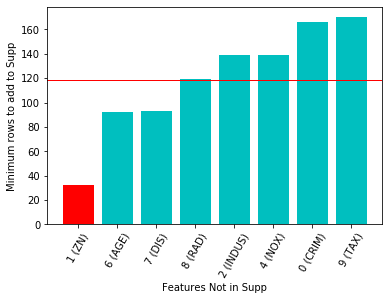

In [7]:
# Plot the results
mean_k = np.asarray(list(target_k_dict.values())).mean()
sorted_target_k_dict = {k: v for k, v in sorted(target_k_dict.items(), key=lambda item: item[1])}
# Set color of minimum feature
colors = ['c']*len(list(target_k_dict.values()))
colors[0] = 'r'
plt.bar(range(len(sorted_target_k_dict)), list(sorted_target_k_dict.values()), align='center', color=colors)
x_ticks = []
for key in list(sorted_target_k_dict.keys()):
    x_ticks.append(str(key) + ' (' + str(features[key]) + ')')
plt.xticks(range(len(sorted_target_k_dict)), x_ticks, rotation=60)
plt.axhline(y=mean_k,linewidth=1, color='r')
plt.xlabel("Features Not in Supp")
plt.ylabel("Minimum rows to add to Supp")
plt.show()

In [10]:
with open('boston_data.pkl', 'wb') as file:
    pickle.dump(sorted_target_k_dict, file)

In [18]:
plt.savefig("boston.png", dpi=300)

<Figure size 432x288 with 0 Axes>

Check if there are any features in the original set of targets that never got added to the Lasso vector, for our given range of $k$. 

In [19]:
# note the values in the target set that never get added to support
set(target_set).difference(target_k_dict.keys())

set()

In [15]:
# Main Loop
K_RANGE = 5000

target_k_dict = dict()
for target in target_set:
    for k in range(K_RANGE):
        poison_rows = k
        
        # Generate poison vectors
        X_poison = np.zeros(shape=(poison_rows, len(lasso_coef)))
        X_poison[:, target] += 1 # switch last column to 1's
        y_poison = np.ones(poison_rows)        

        # Poisoned datasets
        X_poisoned = np.vstack([X, X_poison])
        y_poisoned = np.append(y, y_poison)
        
        # Check poisoned dataset
        if(abs(lasso.fit(X_poisoned,y_poisoned).coef_[target]) > 1e-6):
            target_k_dict[target] = k
            break

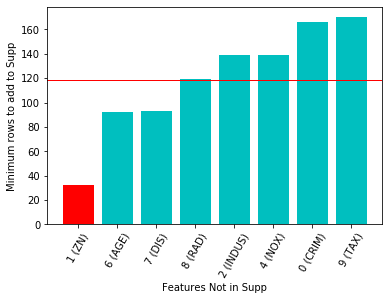

In [16]:
# Plot the results
mean_k = np.asarray(list(target_k_dict.values())).mean()
sorted_target_k_dict = {k: v for k, v in sorted(target_k_dict.items(), key=lambda item: item[1])}
# Set color of minimum feature
colors = ['c']*len(list(target_k_dict.values()))
colors[0] = 'r'
plt.bar(range(len(sorted_target_k_dict)), list(sorted_target_k_dict.values()), align='center', color=colors)
x_ticks = []
for key in list(sorted_target_k_dict.keys()):
    x_ticks.append(str(key) + ' (' + str(features[key]) + ')')
plt.xticks(range(len(sorted_target_k_dict)), x_ticks, rotation=60)
plt.axhline(y=mean_k,linewidth=1, color='r')
plt.xlabel("Features Not in Supp")
plt.ylabel("Minimum rows to add to Supp")
plt.show()